## CSET profiles with MERRA, composited by cloud scene type

The main data structure for this project is going to have to be a data frame, with each entry representing an aircraft profile. There may be an additional data frame for e.g. level legs.
For that, we'll need to parse in every profile from the CSET data. Let's call this build_profile_table. This populates the table from the raw data and saves it to disk, or reloads it from disk. 


rows of the table:  
profile_ID | flight | start_time | end_time |  
    z_i | lwp | dec | 

In [55]:
import os
os.environ['PROJ_LIB'] = '/home/disk/p/jkcm/anaconda3/envs/measures/share/proj'
import sys
sys.path.insert(0, '/home/disk/p/jkcm/Code')

import pandas as pd
pd.options.mode.chained_assignment = None
import datetime as dt
import numpy as np
np.warnings.filterwarnings('ignore')

from Lagrangian_CSET import met_utils as mu
from Lagrangian_CSET import utils as CSET_utils

from classified_cset import utils
from Lagrangian_CSET.CSET_data_classes import CSET_Flight
from tools.decorators import timed
from tools.LoopTimer import LoopTimer
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib as mpl
import xarray as xr
import glob
import seaborn as sns

import pickle
%load_ext autoreload
%autoreload 2
print('boogers')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
boogers


#### PROFILE-BASED ANALYSIS

In [8]:
class_df =  utils.load_class_data('cset')
soundings_file = r'/home/disk/eos4/jkcm/Data/CSET/saved_all_soundings.pickle'
with open(soundings_file, 'rb') as f:
    sounding_data = pickle.load(f)
profiles_file = r'/home/disk/eos4/jkcm/Data/CSET/saved_all_profiles.pickle'
with open(profiles_file, 'rb') as f:
    profile_data = pickle.load(f)

In [162]:
def get_EIS_from_profile(profile):
    
    if 'PSXC' not in profile.keys():
        profile['PSXC'] = profile['PSX']
    i_1000 = np.nonzero(abs(profile['PSXC']-1000)<10)[0]
    i_850 = np.nonzero(abs(profile['PSXC']-850)<10)[0]
    i_700 = np.nonzero(abs(profile['PSXC']-700)<10)[0]
    
    t_1000 = np.nanmean(profile['ATX'][i_1000])
    t_850 = np.nanmean(profile['ATX'][i_850])
    t_700 = np.nanmean(profile['ATX'][i_700])
    z_1000 = np.nanmean(profile['GGALT'][i_1000])
    z_700 = np.nanmean(profile['GGALT'][i_700])
    r_1000 = np.nanmean(profile['RHUM'][i_1000])
    
    return mu.calculate_EIS(t_1000, t_850, t_700, z_1000, z_700, r_1000)

def get_dz(mdata, lat, lon, time, lev=700):
    x = mdata['OMEGA'].sel(lon=lon, lat=lat, method='nearest')
    y = x.sel(method='nearest', time=time, tolerance=np.timedelta64(2, 'h'))
    pres = CSET_utils.pres_map[lev]
    omega_700 = y.sel(lev=pres).values.item()
    x = mdata['AIRDENS'].sel(lon=lon, lat=lat, method='nearest')
    y = x.sel(method='nearest', time=time, tolerance=np.timedelta64(2, 'h'))
    rho_700 = y.sel(lev=pres).values.item()
    dz_700 = omega_700/(9.81*rho_700)
    return dz_700

# def get_divergence(mdata, lat, lon, time):


def build_profile_table(soundings, profiles, classifications, reload=False):
    if reload:
        #unpickle the table from disk and return it
        return
    def get_best_row(lat, lon, date, classifications):
        right_day = classifications[(classifications['datetime'] - date)<np.timedelta64(12,'h')] # should ensure only the right days...
        right_day['dist'] = np.sqrt((right_day['lat']-lat)**2 + (right_day['lon']-lon)**2)
        return right_day.loc[right_day['dist'].idxmin()]
    
    
    df = pd.DataFrame(columns=list(classifications.columns) + 
                      ['type', 'dec', 'zi', 'EIS', 'w_700', 'w_850', 'w_910', 'div_sfc', 'prof_date', 'lcl', 'd_q_inv', 'd_t_inv'])
    scat_data = xr.open_mfdataset(sorted(glob.glob(r'/home/disk/eos9/jkcm/Data/ascat/rss/2015/all/*.nc')),
                                 combine='by_coords')
    with xr.open_mfdataset(sorted(glob.glob(r'/home/disk/eos4/jkcm/Data/CSET/MERRA/unified_2/*.unified*.nc4')),
                          combine='by_coords') as mdata:
        for key,snd in soundings.items():
            lat = np.nanmedian(snd['GGLAT'])
            lon = np.nanmedian(snd['GGLON'])%360
            date = snd['TIME'][int(len(snd['TIME'])/2)]
            best_class = get_best_row(lat, lon, date.replace(tzinfo=None), classifications).copy()
            best_class['type'] = 'sonde'
            best_class['dec'] = snd['dec']['alpha_qt']
            best_class['zi'] = snd['dec']['z_bot']
            best_class['EIS'] = get_EIS_from_profile(snd)
            best_class['w_700'] = get_dz(mdata, lat, lon, date, lev=700)
            best_class['w_850'] = get_dz(mdata, lat, lon, date, lev=850)
            best_class['w_910'] = get_dz(mdata, lat, lon, date, lev=910)
            best_class['prof_date'] = date
            best_class['lcl'] = get_lcl(snd)
            best_class['d_q_inv'] = snd['dec']['d_q_inv']
            best_class['d_t_inv'] = snd['dec']['d_t_inv']
            df = df.append(best_class, ignore_index=True)

        for key,prof in profiles.items():
            lat = prof['dec']['lat']
            lon = prof['dec']['lon']%360
            date = utils.as_datetime(prof['dec']['time'])
            best_class = get_best_row(lat, lon, date.replace(tzinfo=None), classifications).copy()
            best_class['type'] = 'prof'
            best_class['dec'] = prof['dec']['alpha_qt']
            best_class['zi'] = prof['dec']['z_bot']
            best_class['EIS'] = get_EIS_from_profile(prof['sounding'])
            best_class['w_700'] = get_dz(mdata, lat, lon, date, lev=700)
            best_class['w_850'] = get_dz(mdata, lat, lon, date, lev=850)
            best_class['w_910'] = get_dz(mdata, lat, lon, date, lev=910)
            best_class['prof_date'] = date
            best_class['lcl'] = get_lcl(prof['sounding'])
            best_class['d_q_inv'] = prof['dec']['d_q_inv']
            best_class['d_q_inv'] = prof['dec']['d_q_inv']
            df = df.append(best_class, ignore_index=True)
    return df
    #read in all flight dates
#     return

soundings = sounding_data
profiles = profile_data
classifications = class_df
df = build_profile_table(soundings, profiles, classifications, reload=False)
print('bananas')

bananas


In [105]:
def get_lcl(prof):
    alt = prof['GGALT']
    low_idx = np.where(alt<np.min(alt)+50)
    pres = np.nanmean(prof['PSXC'][low_idx])*100
    temp = np.nanmean(prof['ATX'][low_idx])
    rh = np.nanmean(prof['RHUM'][low_idx])/100
    lcl = mu.lcl(pres,temp,rhl=rh)
    return lcl

In [158]:
profiles[list(profiles.keys())[0]]['dec']

{'d_qt': -1.66992,
 'd_theta_e': -3.6927185,
 'd_theta_l': 0.8977661,
 'alpha_thetal': 0.070839636,
 'alpha_qt': 0.3099389,
 'alpha_thetae': 1.8614414,
 'd_q_inv': -6.270227,
 'd_t_inv': 7.259745209723762,
 't_below_inv': 279.12,
 't_above_inv': 286.37974032691125,
 'q_below_inv': 7.218786,
 'q_above_inv': 0.9485588,
 'z_top': 1713.4137,
 'z_mid': 1612.6903,
 'z_bot': 1521.5885,
 'i_top': 781,
 'i_mid': 793,
 'i_bot': 804,
 'lat': 37.872627,
 'lon': -129.24213,
 'lon_p': -128.2446502685547,
 'time': numpy.datetime64('2015-07-07T15:46:48.000000000')}

In [100]:
alt = profiles[list(profiles.keys())[0]]['GGALT']
low_idx = np.where(alt<np.min(alt)+50)
pres = np.nanmean(soundings[list(soundings.keys())[0]]['PSXC'][low_idx])*100
temp = np.nanmean(soundings[list(soundings.keys())[0]]['ATX'][low_idx])
rh = np.nanmean(soundings[list(soundings.keys())[0]]['RHUM'][low_idx])/100
lcl = mu.lcl(pres,temp,rhl=rh)

KeyError: 'GGALT'

In [108]:
grouped = df.groupby('cat')

In [109]:
df['class'] = df.apply(lambda x: utils.short_labels[x['cat']], axis=1)
df['w_700'] = df['w_700'] * 1000
df['w_850'] = df['w_850'] * 1000
df['w_910'] = df['w_910'] * 1000
grouped = df.groupby('cat')
print('bananas')

bananas


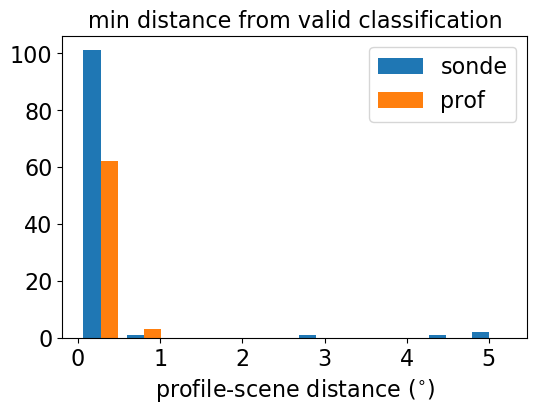

In [24]:
types = df.type.unique()
fig, ax = plt.subplots()
ax.hist([df.loc[df.type == x, 'dist'] for x in types], label=types)
ax.legend()
ax.set_xlabel('profile-scene distance ($^{\circ}$)')
ax.set_title('min distance from valid classification');

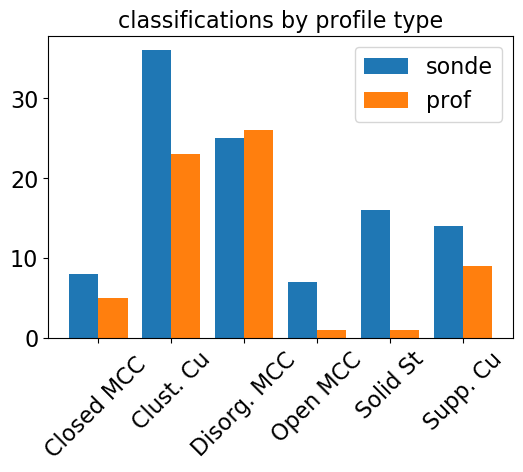

In [8]:
types = df.type.unique()
fig, ax = plt.subplots()
ax.hist([df.loc[df.type == x, 'cat'] for x in types], bins=np.arange(7)-0.5, label=types)
ax.legend()
ax.set_title('classifications by profile type')
ax.set_xticks(np.arange(6))
ax.set_xticklabels([utils.short_labels[i] for i in ax.get_xticks()], rotation=45);

In [12]:
def plot_grouped_var_dists(grouped, varname, xlims=None, xlabel=None, ax=None, savename=None, verbose=False, scale=None):
    if not ax:
        fig, ax = plt.subplots(figsize=(10,6))
    else:
        fig = ax.figure
    colors = [mpl.cm.get_cmap('viridis')(i) for i in np.linspace(0,1,6)]
    lss = ['-',(0,(5,1,5,1)),(0,(4,1,1,1)),(0,(1,3,1,3)),(0,(2,1,1,1,1,1)),(0,(1,2,1,2))]
    ordering = [4, 0, 2, 3, 1, 5]
    for i, name in enumerate(ordering):
        group = grouped.get_group(name)
        if verbose:
            print(utils.short_labels[name]+':', len(group), sum(~np.isnan(group[varname].values)))
        sns.distplot(group[varname].values, hist = False, kde = True,
                     kde_kws = {'shade': True, 'linewidth': 3, 'linestyle': lss[i]},#, 'bw': scale},
#                      hist_kws = {'histtype': 'step', 'linewidth': 2, 'alpha': 1},
                     label = utils.short_labels[name], color=colors[i], ax=ax)
        if xlims:
            ax.set_xlim(xlims)
        if xlabel:
            ax.set_xlabel(xlabel)
        ax.set_ylabel("normed density")
        ax.set_yticklabels
        if savename:
            fig.savefig(savename, bbox_inches='tight')
        
    return fig, ax

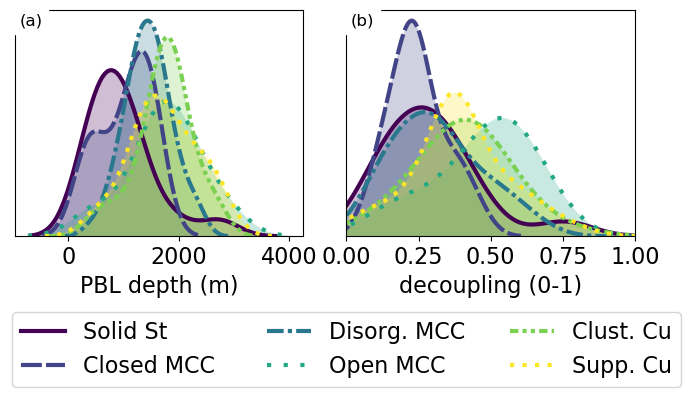

In [110]:
fig, [ax1, ax2] = plt.subplots(figsize=(8, 3), nrows=1, ncols=2)
plot_grouped_var_dists(grouped=grouped, varname='zi', xlabel='PBL depth (m)', 
                       ax=ax1, savename=None, verbose=False, scale=0.4)
plot_grouped_var_dists(grouped=grouped, varname='dec', xlims=(0, 1), xlabel='decoupling (0-1)', 
                       ax=ax2, savename=None, verbose=False, scale=0.4);
# plot_grouped_var_dists(grouped=grouped, varname='EIS', xlims=None, xlabel='EIS (K)', 
#                        ax=ax3, savename=None, verbose=False);
# plot_grouped_var_dists(grouped=grouped, varname='low_cf', xlims=(0, 1), xlabel="Cloud Fraction", 
#                        ax=ax4, savename=None, verbose=True);
for axi in [ax1, ax2]:#, ax3, ax4]:
    axi.get_legend().remove()
    axi.get_yaxis().set_ticks([])
    axi.set_ylabel('')

ax2.legend(loc='center', bbox_to_anchor=(0., -0.5), ncol=3)
    
plt.subplots_adjust(wspace=0.15)

for i, axi in enumerate([ax1, ax2]):
        letter = chr(ord('a') + i)
        axi.text(0.015, 0.985, f'({letter})', fontsize=12, horizontalalignment='left', verticalalignment='top', transform=axi.transAxes,
                backgroundcolor='w')
        
# fig.savefig('/home/disk/p/jkcm/plots/measures/final/cset_hists.png', bbox_inches='tight')        
        
        
# depth_savename = '/home/disk/p/jkcm/plots/measures/cset_depth_by_category.png'
# plot_grouped_var_dists(grouped_df=grouped, varname='zi', xlabel='PBL depth (m)', 
#                        ax=None, savename=depth_Savename, verbose=True);
# dec_savename = '/home/disk/p/jkcm/plots/measures/cset_decoupling_by_category.png'
# plot_grouped_var_dists(grouped_df = grouped, varname='dec', xlims=(0, 1), xlabel='decoupling (0-1)', 
#                        ax=None, savename=dec_savename, verbose=False);
# EIS_savename = '/home/disk/p/jkcm/plots/measures/cset_EIS_by_category.png'
# plot_grouped_var_dists(grouped_df = grouped, varname='EIS', xlims=None, xlabel='EIS (K)', 
#                        ax=None, savename=EIS_savename, verbose=False);
# subs_savename = '/home/disk/p/jkcm/plots/measures/cset_subsidence_by_category.png'
# plot_grouped_var_dists(grouped_df = grouped, varname='w_700', xlims=(-10, 20), xlabel="w$_{700}$ (mm/s)", 
#                        ax=None, savename=subs_savename, verbose=False);

In [117]:
decs, zis, lcls = df.dec.values, df.zi.values, df.lcl.values
idx = np.all([~np.isnan(decs), ~np.isnan(zis), ~np.isnan(lcls)], axis=0)
decs, zis, lcls = decs[idx], zis[idx], lcls[idx]
cld_layer = zis-lcls

(array([14., 19., 23., 22., 25., 29., 11.,  9.,  5.,  6.]),
 array([  64.78291851,  296.95218953,  529.12146055,  761.29073158,
         993.4600026 , 1225.62927362, 1457.79854465, 1689.96781567,
        1922.13708669, 2154.30635771, 2386.47562874]),
 <a list of 10 Patch objects>)

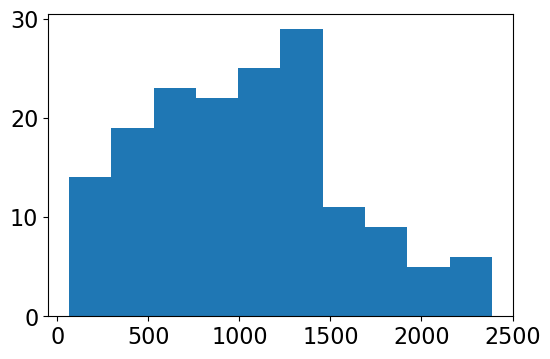

In [118]:
plt.hist(cld_layer)

(0, 1)

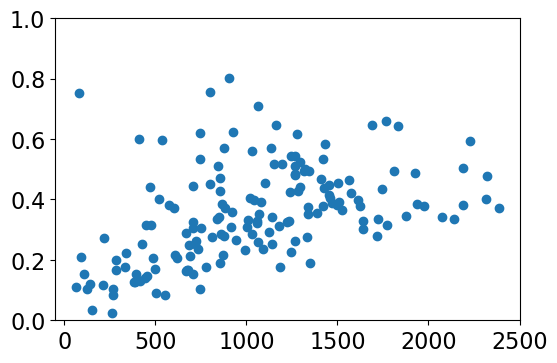

In [127]:
fig, ax = plt.subplots()
ax.scatter(cld_layer, decs)
ax.set_ylim((0,1))

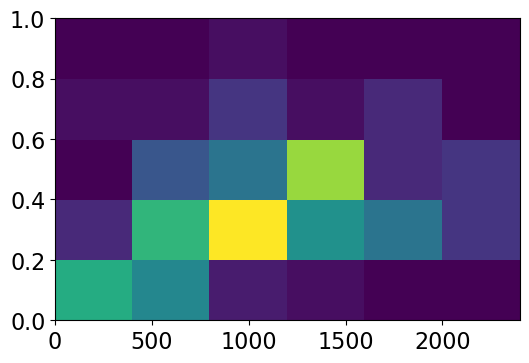

In [149]:
counts,ybins,xbins,image = plt.hist2d(cld_layer,decs,bins = (np.arange(0,2500,400), np.arange(0, 1.01, 0.2)));

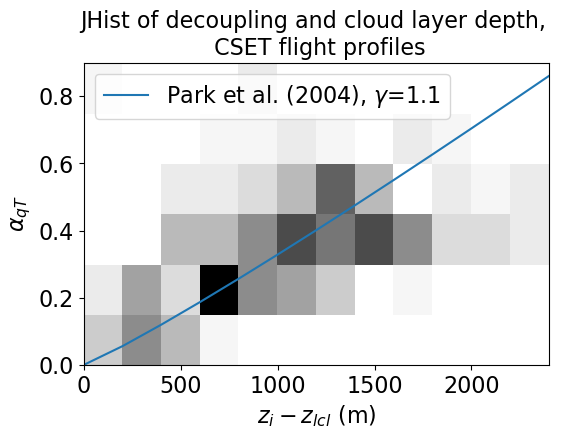

In [155]:
fig, ax = plt.subplots()
ax.hist2d(cld_layer, decs, bins = (np.arange(0,2500,200), np.arange(0, 1.01, 0.15)), density=True, cmap='Greys')
# ax.contour(counts,extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()],linewidths=3)
lcls = np.arange(0,2500,200)
alphs = (lcls/2750)**1.1
ax.plot(lcls, alphs, label=r'Park et al. (2004), $\gamma$=1.1')
ax.set_ylabel(r'$\alpha_{qT}$')
ax.set_xlabel('$z_i-z_{lcl}$ (m)')
ax.set_title('JHist of decoupling and cloud layer depth, \n CSET flight profiles')
ax.legend()

In [188]:
dqs, dts, low_cf = df.d_q_inv.values, df.d_t_inv.values, df.low_cf.values
idx = np.all([~np.isnan(dqs), ~np.isnan(dts), ~np.isnan(low_cf), dqs<15], axis=0)
dqs, dts, low_cf = dqs[idx], dts[idx], low_cf[idx]
kappa = 1 + (dts)/((2260/1006)*dqs)

(array([ 1.,  0.,  0.,  0.,  0.,  0., 32., 47.,  1.,  1.]),
 array([-38.39539149, -32.83859178, -27.28179206, -21.72499235,
        -16.16819264, -10.61139293,  -5.05459321,   0.5022065 ,
          6.05900621,  11.61580592,  17.17260564]),
 <a list of 10 Patch objects>)

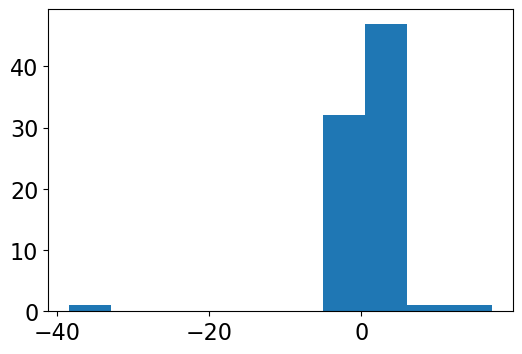

In [192]:
plt.hist(kappa)

(-1, 1)

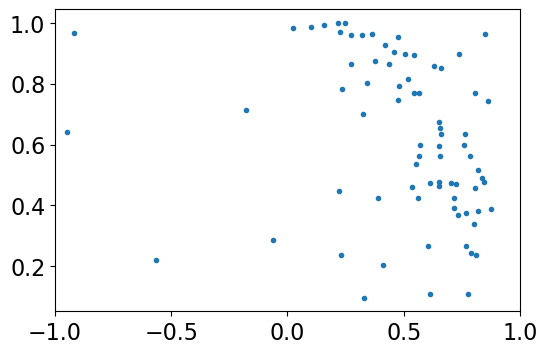

In [196]:
fig, ax = plt.subplots()
ax.plot(kappa, low_cf, '.')
ax.set_xlim((-1,1))

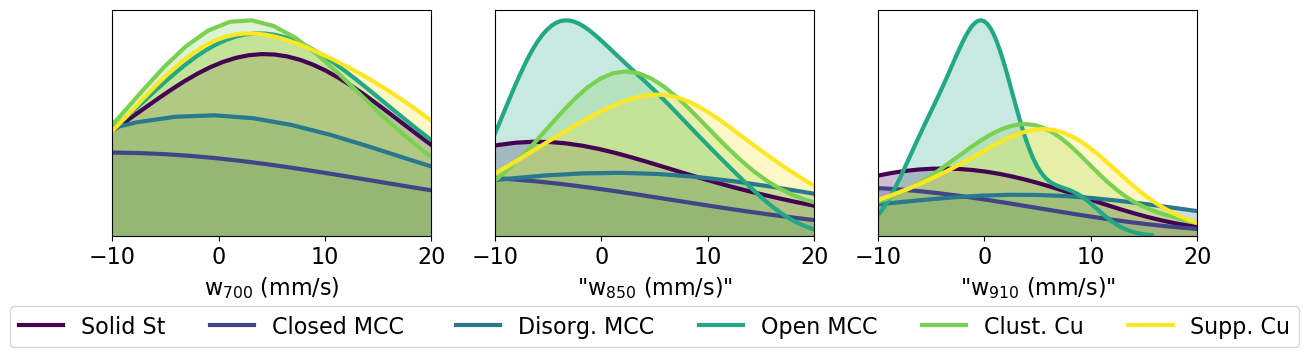

In [11]:
# fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(figsize=(10, 6), nrows=2, ncols=2)
fig, [ax1, ax2, ax3] = plt.subplots(figsize=(14, 3), nrows=1, ncols=3)
plot_grouped_var_dists(grouped=grouped, varname='w_700', xlims = (-10, 20), xlabel="w$_{700}$ (mm/s)", 
                       ax=ax1, savename=None, verbose=False)
plot_grouped_var_dists(grouped=grouped, varname='w_850', xlims=(-10, 20), xlabel='"w$_{850}$ (mm/s)"', 
                       ax=ax2, savename=None, verbose=False);
plot_grouped_var_dists(grouped=grouped, varname='w_910', xlims=(-10, 20), xlabel='"w$_{910}$ (mm/s)"', 
                       ax=ax3, savename=None, verbose=False);
# plot_grouped_var_dists(grouped_df = grouped, varname='w_700', xlims=(-10, 20), xlabel="w$_{700}$ (mm/s)", 
#                        ax=ax4, savename=None, verbose=False);
fig.subplots_adjust(hspace=0.4)
for axi in [ax1, ax2, ax3]:#, ax4]:
    axi.get_legend().remove()
    axi.get_yaxis().set_ticks([])
    axi.set_ylabel('')
    
ax2.legend(loc='center', bbox_to_anchor=(0.5, -0.4), ncol=6)



#### ABOVE-CLOUD LEG-BASED ANALYSIS

In [5]:
# Get all level legs from all flights
# MFdataset the entire MODIS dataset 
# do the same as above

lt = LoopTimer(len(CSET_utils.datemap.values()))
all_level_legs = []
for i in range(15):
# for i in [6]:
    lt.update()
    f = CSET_Flight('RF{:02d}'.format(i+1))
    f_legs = f.split_into_legs(legs = ['p', 'c'])
    for leg_type, legdict in f_legs.items():
        for k, v in legdict.items():
            cloud_masked = CSET_utils.get_cloud_only_vals(v)
            if len(cloud_masked['time'])<30:
#                 print(f'skipping flight {i+1}, seq {k}, leg {leg_type}')
                continue
            nd = np.nanmedian(cloud_masked['CONCD_LWOI'])
            lat = np.nanmedian(cloud_masked['GGLAT'])
            lon = np.nanmedian(cloud_masked['GGLON'])
            time = cloud_masked['time'][int(len(cloud_masked['time'])/2)].values
#             print(f'appending flight {i+1}, seq {k}, leg {leg_type}')
            all_level_legs.append(dict(nd=nd, lat=lat, lon=lon, time=time, ltype=leg_type, leg=k, flight=i))



93.75%      ETA 01:16:18      time left: 49 seconds         

In [1]:
def build_cloud_leg_table(all_level_legs, classifications, reload=False):
    if reload:
        #unpickle the table from disk and return it
        return
    def get_best_row(lat, lon, date, classifications):
        right_day = classifications[(classifications['datetime'] - date.replace(tzinfo=None))<np.timedelta64(12,'h')] # should ensure only the right days...
        right_day['dist'] = np.sqrt((right_day['lat']-lat)**2 + (right_day['lon']-lon)**2)
        return right_day.loc[right_day['dist'].idxmin()]
    
    df = pd.DataFrame(columns=list(classifications.columns) + 
                      ['type', 'ac_nd'])
#     with xr.open_mfdataset(sorted(glob.glob(r'/home/disk/eos4/jkcm/Data/CSET/MERRA/unified_2/*.unified*.nc4'))) as mdata:
    if True:
        for pt in all_level_legs:
            best_class = get_best_row(pt['lat'], pt['lon'], utils.as_datetime(pt['time']), classifications)
#             best_class['type'] = pt['ltype']
            df = df.append(best_class, ignore_index=True)
    return df

classifications = class_df
df = build_cloud_leg_table(all_level_legs, classifications, reload=False)

NameError: name 'class_df' is not defined

In [20]:
grouped = df.groupby('cat')

ZeroDivisionError: 0.0 cannot be raised to a negative power

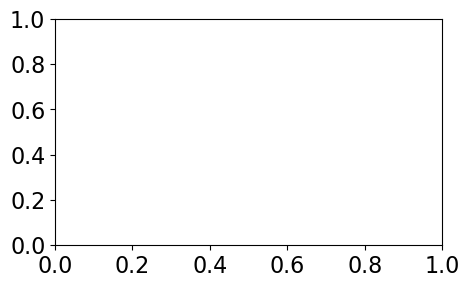

In [127]:
# fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(figsize=(10, 6), nrows=2, ncols=2)
fig, ax1 = plt.subplots(figsize=(5, 3))
plot_grouped_var_dists(grouped_df=grouped, varname='ac_nd', xlabel="ac nd", 
                       ax=ax1, savename=None, verbose=False)
# plot_grouped_var_dists(grouped_df = grouped, varname='w_700', xlims=(-10, 20), xlabel="w$_{700}$ (mm/s)", 
#                        ax=ax4, savename=None, verbose=False);
# fig.subplots_adjust(hspace=0.4)
# for axi in [ax1, ax2, ax3]:#, ax4]:
#     axi.get_legend().remove()
#     axi.get_yaxis().set_ticks([])
#     axi.set_ylabel('')
    
# ax2.legend(loc='center', bbox_to_anchor=(0.5, -0.4), ncol=6)



In [199]:
# @timed
def build_all_profiles():
    all_profiles = {}
    all_soundings  = {}
    lt = LoopTimer(len(CSET_utils.datemap.values()))
    for i in range(15):
        lt.update()
        f = CSET_Flight('RF{:02d}'.format(i+1))
#         f.add_ERA_data()
        f.add_AVAPS_data()
        
        #profiles
#         profs = f.get_profiles()
#         for k,v in profs.items():
#             all_profiles['RF{:02d}{}'.format(i+1, k)] = v
    
        
        for (d,sounding) in f.AVAPS_profiles.items():
            sounding['PSXC'] = sounding['PSX']
            decoupling_dict = mu.calc_decoupling_and_inversion_from_sounding(sounding, usetheta=False, smooth_t=False)
            sounding['dec'] = decoupling_dict
            all_soundings['RF{:02d}{}'.format(i+1, d)] = sounding
    
        del f
    return all_profiles, all_soundings
_, all_soundings = build_all_profiles()
# savefile = r'/home/disk/eos4/jkcm/Data/CSET/saved_all_profiles.pickle'
# with open(savefile, 'wb') as f:
#     pickle.dump(all_profiles,f)   
savefile = r'/home/disk/eos4/jkcm/Data/CSET/saved_all_soundings.pickle'
with open(savefile, 'wb') as f:
    pickle.dump(all_soundings,f)   


93.75%      ETA 02:01:07      time left: 41 seconds         